# **Install dependencies**

In [1]:
!pip install torch nltk unidecode emoji emoticon_fix lime joblib imbalanced-learn
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 21.7 MB/s eta 0:00:00

# **Import libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import re, nltk, emoji, emoticon_fix, torch, joblib, traceback
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import *
from sklearn.neural_network import MLPClassifier
from transformers import *
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lime.lime_text import LimeTextExplainer
import logging

TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


# **Set Up Logging**
---
Logging helps us keep track of what's happening during training, like a diary for our code.
We'll save this diary (log) to a file called 'training.log'.

In [3]:
logging.basicConfig(filename='training.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# **Download Stopwords**

---
Downloads NLTK stopwords and related resources for text preprocessing.


In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
snow_stemmer = SnowballStemmer(language='english')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# **Check Dataset Labels**

---
Loads and inspects initial dataset files (train, dev, test) to verify label distributions.


In [5]:
# Load CSV files
train_df = pd.read_csv('cleansed_train.csv')
dev_df = pd.read_csv('cleansed_dev.csv')
test_df = pd.read_csv('cleansed_test.csv')

print("Size of new_train.csv:", len(train_df))
print("Size of new_dev.csv:", len(dev_df))
print("Size of new_test.csv:", len(test_df))

Size of new_train.csv: 30160
Size of new_dev.csv: 2755
Size of new_test.csv: 5509


# **Look at sample data**

In [6]:
print("Train columns:", train_df.columns)
print("Train first few rows:", train_df.head())
print("Train label counts:", train_df['label'].value_counts())
logger.info("Datasets loaded successfully.")

Train columns: Index(['turn1', 'turn2', 'turn3', 'label'], dtype='object')
Train first few rows:                   turn1                                              turn2  \
0  don't worry i'm girl                       hmm how do i know if you are   
1          when did i ?                         saw many times i think - -   
2                    by                                   by google chrome   
3      u are ridiculous  i might be ridiculous but i am telling the tru...   
4    just for time pass                       wt do you do 4 a living then   

                       turn3   label  
0         what's your name ?  others  
1       no . i never saw you   angry  
2             where you live  others  
3  u little disgusting whore   angry  
4                      maybe  others  
Train label counts: label
others    14948
angry      5506
sad        5463
happy      4243
Name: count, dtype: int64


# **Preprocess Data**


---


Names of the preprocessing steps from the code:

- Remove URLs
- Remove special characters
- Preserve [SEP]: separator to concatenate the turns
- Normalize spaces
- Convert to lowercase and strip whitespace
- Convert accented characters (unidecode)
- Convert emojis (demojize)
- Fix emoticons (emoticon_fix)
- Lemmatization and remove stopwords

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s\[SEP\]]", "", text)  # Remove special characters but preserve [SEP]
    text = re.sub(r"\s+", " ", text)  # Normalize spaces
    text = text.lower().strip()
    text = unidecode(text)  # Convert accented characters
    text = emoji.demojize(text)  # Convert emojis
    text = emoticon_fix.emoticon_fix(text)  # Use available emoticon_fix
    words = text.split()
    custom_stop_words = set(stop_words) - {'i', 'you', 'not', 'am', 'are', 'but', 'or', 'because', 'is', 'was', 'were', 'my', 'your', 'me', 'very', 'so', 'too'}
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in custom_stop_words]
    return " ".join(words)

# Ensure no missing values
train_df = train_df.dropna(subset=['turn1', 'turn2', 'turn3', 'label'])
dev_df = dev_df.dropna(subset=['turn1', 'turn2', 'turn3', 'label'])
test_df = test_df.dropna(subset=['turn1', 'turn2', 'turn3', 'label'])

# Combine the three turns with [SEP] separator and preprocess
separator = "[SEP]"
train_df['text'] = (train_df['turn1'] + separator + train_df['turn2'] + separator + train_df['turn3']).apply(preprocess_text)
dev_df['text'] = (dev_df['turn1'] + separator + dev_df['turn2'] + separator + dev_df['turn3']).apply(preprocess_text)
test_df['text'] = (test_df['turn1'] + separator + test_df['turn2'] + separator + test_df['turn3']).apply(preprocess_text)

# Verify a few samples to ensure [SEP] is preserved
print("Sample preprocessed texts from train_df:", train_df['text'].head().tolist())
print("Sample preprocessed texts from dev_df:", dev_df['text'].head().tolist())
print("Sample preprocessed texts from test_df:", test_df['text'].head().tolist())

# Label mapping and ensure integer type
label_map = {'happy': 0, 'sad': 1, 'angry': 2, 'others': 3}
train_df['label'] = train_df['label'].map(label_map).astype('Int64')
dev_df['label'] = dev_df['label'].map(label_map).astype('Int64')
test_df['label'] = test_df['label'].map(label_map).astype('Int64')

# Save processed data
train_df.to_csv("new_train.csv", index=False)
dev_df.to_csv("new_dev.csv", index=False)
test_df.to_csv("new_test.csv", index=False)

Sample preprocessed texts from train_df: ['dont worry im girl [ sep ] hmm i know you are [ sep ] whats your name', 'i [ sep ] saw many time i think [ sep ] i never saw you', '[ sep ] google chrome [ sep ] you live', 'u are ridiculous [ sep ] i might ridiculous but i am telling truth [ sep ] u little disgusting whore', 'time pas [ sep ] wt you 4 living [ sep ] maybe']
Sample preprocessed texts from dev_df: ['dont ask me [ sep ] youre guy not you would understand [ sep ] im not guy fuck', 'mixed thing [ sep ] thing you [ sep ] you seen minion', 'today im very happy [ sep ] im happy you [ sep ] i marry', 'woah bring me [ sep ] left oops [ sep ] brb', 'is thooooo [ sep ] i said soon master [ sep ] is pressuring me']
Sample preprocessed texts from test_df: ['hmm [ sep ] your bio mean [ sep ] i dont bio', 'you like [ sep ] very little thing [ sep ] ok', 'yes [ sep ] so [ sep ] i want fuck babu', 'you guess [ sep ] [ sep ] fuck', '[ sep ] course [ sep ] gender movie you like']


# **Check and load the preprocessed data instances**

In [9]:
print("Number of instances in preprocessed train data:", len(train_df))
print("Number of instances in preprocessed dev data:", len(dev_df))
print("Number of instances in preprocessed test data:", len(test_df))
logger.info("Data preprocessing completed.")

Number of instances in preprocessed train data: 28697
Number of instances in preprocessed dev data: 2690
Number of instances in preprocessed test data: 5354


In [10]:
train_df = pd.read_csv('new_train.csv')
dev_df = pd.read_csv('new_dev.csv')
test_df = pd.read_csv('new_test.csv')

# **Visualizing Instances**

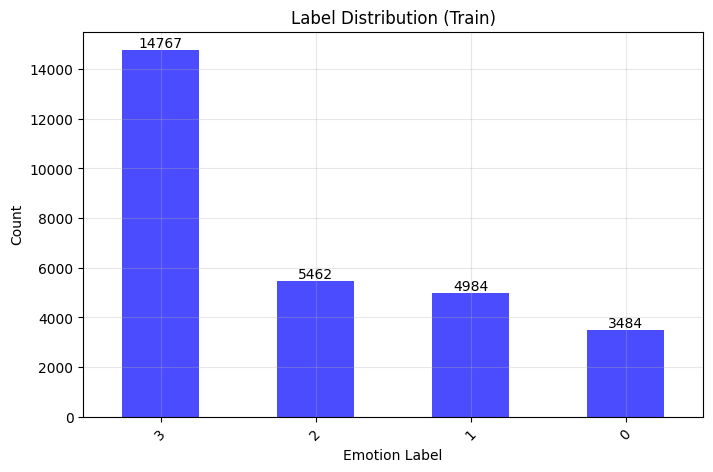

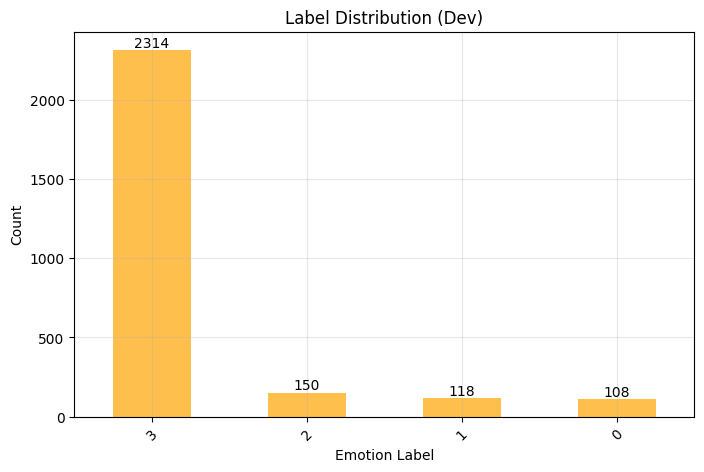

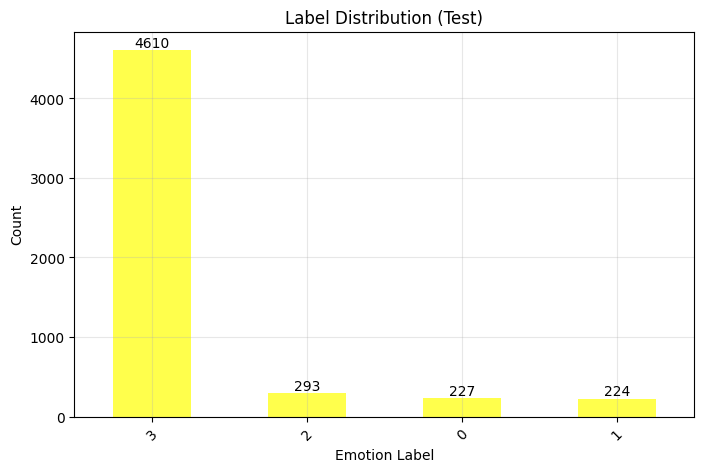

In [ ]:
# Plot 1: Label distribution for Train
train_label_counts = train_df['label'].value_counts()
plt.figure(figsize=(8, 5))
bars = train_label_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.title('Label Distribution (Train)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for i, v in enumerate(train_label_counts):
    bars.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

# Plot 2: Label distribution for Dev
dev_label_counts = dev_df['label'].value_counts()
plt.figure(figsize=(8, 5))
bars = dev_label_counts.plot(kind='bar', color='orange', alpha=0.7)
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.title('Label Distribution (Dev)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for i, v in enumerate(dev_label_counts):
    bars.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

# Plot 3: Label distribution for Test
test_label_counts = test_df['label'].value_counts()
plt.figure(figsize=(8, 5))
bars = test_label_counts.plot(kind='bar', color='yellow', alpha=0.7)
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.title('Label Distribution (Test)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for i, v in enumerate(test_label_counts):
    bars.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

# **TRANSFORMER**

## **Create Dataset class**

---
Creates *EmoContextDataset* class to organize text and labels so the model can understand and learn from them easily.


In [91]:
class EmoContextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        # Explicitly convert each item in texts to string
        string_texts = [str(t) for t in texts]
        # Pass the list of strings to the tokenizer
        self.encodings = tokenizer(string_texts, padding=True, truncation=True, max_length=384, return_tensors="pt")
        self.labels = torch.tensor(list(labels), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: dev[idx] for key, dev in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

## **Custom Trainer with weighted loss**

---
Makes a special trainer to help the model pay attention to all emotions fairly, especially the less common ones.


In [92]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

## **Compute Metrics**

---
Sets up a quick way to check how good the model is by measuring accuracy and F1 score, like a report card.


In [93]:
# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": classification_report(labels, predictions, output_dict=True)['weighted avg']['f1-score']
    }

## **Initialize Tokenizer**

---
This code initializes a DistilBERT tokenizer from the pre-trained "distilbert-base-uncased" model to convert text into a format suitable for the model.


In [94]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/config.json
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_

## **Use the preprocessed train and dev dataframes directly**

---
This code splits the training and development data into text features and their corresponding labels.

In [95]:
X_train = train_df[['text']]
y_train = train_df['label']
X_dev = dev_df[['text']]
y_dev = dev_df['label']

## **Create datasets**

---
This code creates custom datasets to prepare the training and development data for use with the model.

In [96]:
train_dataset = EmoContextDataset(X_train['text'].tolist(), y_train.tolist(), tokenizer)
dev_dataset = EmoContextDataset(X_dev['text'].tolist(), y_dev.tolist(), tokenizer)

## **Create DataLoader**

---
This code creates PyTorch *DataLoader* objects for the training and development datasets, which will be used to efficiently feed data to the model in batches during training and evaluation.

In [97]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

## **Initialize model**

---
This code initializes a DistilBERT model for sequence classification with 4 output labels from a pre-trained checkpoint.


In [98]:
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=4)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/config.json
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,

## **Dropout**

In [99]:
model.config.hidden_dropout_prob = 0.4

## **Define optimizer**

---
This code uses an algorithm to update the model's parameters during training to minimize the loss function.


In [100]:
albert_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## **Define Training Arguments and Initialize Trainer**

---
This code defines the training settings and initializes the Hugging Face Trainer object for managing the training process.


In [101]:
# Training arguments
training_args = TrainingArguments(
    output_dir=f"./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir=f"./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=True,
    report_to="none",
    save_on_each_node=False,
    disable_tqdm=False
)

# Initialize Trainer (no class weights, using oversampling instead)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(albert_optimizer, None),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

PyTorch: setting up devices
<ipython-input-101-3326452056>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend


## **Train model**

---
This code trains the model using the Hugging Face Trainer.


In [ ]:
trainer.train()

## **Classification Report (TRANSFORMER)**

In [ ]:
print("\nGenerating Classification Reports and Micro Averages...\n" + "-" * 50)

# Train Set Evaluation
train_preds = trainer.predict(train_dataset).predictions
train_preds = np.argmax(train_preds, axis=1)

print("\nTrain Set Classification Report:")
# print(classification_report(y_train, train_preds, digits=4))

# print(f"\nTraining Set Micro Averages:")
print('Recall Score:', recall_score(y_train, train_preds, average='micro'))
print('Precision Score:', precision_score(y_train, train_preds, average='micro'))
print('Micro Avg. F1 Score:', f1_score(y_train, train_preds, average='micro'))
print('Accuracy:', accuracy_score(y_train, train_preds))

# Development Set Evaluation
dev_preds = trainer.predict(dev_dataset).predictions
dev_preds = np.argmax(dev_preds, axis=1)

print("\nDevelopment Set Classification Report:")
# print(classification_report(dev_df['label'].tolist(), test_preds, digits=4))

# print(f"\nDevelopment Set Micro Averages:")
print('Recall Score:', recall_score(dev_df['label'].tolist(), dev_preds, average='micro'))
print('Precision Score:', precision_score(dev_df['label'].tolist(), dev_preds, average='micro'))
print('Micro Avg. F1 Score:', f1_score(dev_df['label'].tolist(), dev_preds, average='micro'))
print('Accuracy:', accuracy_score(dev_df['label'].tolist(), dev_preds))

print("-" * 50)

# **SEQUENTIAL LEARNING**

## **Extract model features**

---
Pulls out important bits (features) from the model to use in the next steps, like finding clues.

In [ ]:
def extract_albert_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Last hidden layer
            features.append(hidden_states[:, 0, :].cpu().numpy())  # CLS token
    return np.vstack(features)

## **Define Dataset Classes**
---
This code defines a custom dataset class to prepare text data and labels for use with a model.


In [ ]:
class AlBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        string_texts = [str(t) for t in texts]
        self.encodings = tokenizer(string_texts, padding=True, truncation=True, max_length=384, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: dev[idx] for key, dev in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

## **Define Dataset Classes**
* * *
This code defines a custom dataset class to prepare pre-extracted features and labels for use with an LSTM model.

In [ ]:
class LSTMFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1, input_dim)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## **Define BiLSTM Model**

* * *
This code defines a Bidirectional LSTM (BiLSTM) model in PyTorch for sequence processing.

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional doubles hidden size

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def extract_features(self, x):
        out, _ = self.lstm(x)
        return out[:, -1, :] # Return the output of the LSTM layer before the linear layer

## **Set Device and Move Model**

* * *
This code determines the available device (CPU or CUDA) and moves the model to that device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## **Prepare DistilBERT Datasets and DataLoaders**

* * *
This code prepares custom datasets and data loaders for the DistilBERT model using the tokenized text and labels.

In [ ]:
train_dataset = AlBertDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
dev_dataset = AlBertDataset(dev_df['text'].tolist(), dev_df['label'].tolist(), tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

## **Extract and Normalize DistilBERT Features**

* * *
This code extracts features from the DistilBERT model and normalizes them using `StandardScaler`.

In [ ]:
train_features = extract_albert_features(model, train_dataloader, device)
dev_features = extract_albert_features(model, dev_dataloader, device)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
dev_features = scaler.transform(dev_features)

## **Apply SMOTE to balance classes**

---
SMOTE is a technique that creates synthetic samples for minority classes to balance the dataset during training.

In [ ]:
# Identify the number of samples in the majority class
majority_class_count = train_df['label'].value_counts().max()

# Define the sampling strategy to oversample minority classes to the majority class count
sampling_strategy = {label: majority_class_count for label in np.unique(train_df['label']) if train_df['label'].value_counts()[label] < majority_class_count}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

train_features_smote, train_labels_smote = smote.fit_resample(train_features, train_df['label'])
print("Train label counts after SMOTE:", pd.Series(train_labels_smote).value_counts())

## **Prepare BiLSTM datasets with SMOTE-balanced data**

In [ ]:
train_lstm_dataset = LSTMFeatureDataset(train_features_smote, train_labels_smote)
dev_lstm_dataset = LSTMFeatureDataset(dev_features, dev_df['label'].tolist())
train_loader = DataLoader(train_lstm_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_lstm_dataset, batch_size=64, shuffle=False)

## **Initialize BiLSTM model**

---
This code initializes the BiLSTM model and moves it to the device for computation.


In [ ]:
bilstm_model = BiLSTM(input_dim=train_features.shape[1], hidden_dim=256, output_dim=4, dropout=0.3).to(device)

## **Optimizer and Loss**

---

This code defines the optimizer, loss function, and learning rate scheduler for training the BiLSTM model.

In [ ]:
bilstm_optimizer = torch.optim.AdamW(bilstm_model.parameters(), lr=2e-4 )
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(bilstm_optimizer, mode='min', factor=0.5, patience=2)

## **Train BiLSTM model with Development Evaluation and Early Stopping**

* * *
This code trains the BiLSTM model, evaluates its performance on the development set, and uses early stopping to prevent overfitting.

In [ ]:
# Training loop with Development
num_epochs = 10
best_dev_loss = float('inf')
patience = 3
trigger_times = 0
for epoch in range(num_epochs):
    bilstm_model.train()
    total_train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        bilstm_optimizer.zero_grad()
        outputs = bilstm_model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        bilstm_optimizer.step()
        total_train_loss += loss.item()

    # Development
    bilstm_model.eval()
    total_dev_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_features, batch_labels in dev_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = bilstm_model(batch_features)
            loss = criterion(outputs, batch_labels)
            total_dev_loss += loss.item()
            all_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_dev_loss = total_dev_loss / len(dev_loader)
    dev_accuracy = accuracy_score(all_labels, np.argmax(all_preds, axis=1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    if avg_dev_loss < best_dev_loss:
        best_dev_loss = avg_dev_loss
        trigger_times = 0
        torch.save(bilstm_model.state_dict(), 'best_bilstm_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break
    scheduler.step(avg_dev_loss)

In [ ]:
bilstm_model.eval()

## **Evaluate BiLSTM on Development Set**

* * *
This code evaluates the BiLSTM model on the development set and extracts predictions and true labels.

In [ ]:
# Evaluate on Development set
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_features, batch_labels in dev_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = bilstm_model(batch_features)
        all_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Convert lists to numpy arrays for evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute predicted labels
predicted_labels = np.argmax(all_preds, axis=1)

## **Classification Report (SEQUENTIAL LEARNING)**

In [ ]:
print("\nDevelopment Set Classification Report (After BiLSTM):")
# print(classification_report(all_labels, predicted_labels, digits=4))

# print(f"\nDevelopment Set Micro Averages (After BiLSTM):")
print('Recall Score:', recall_score(all_labels, predicted_labels, average='micro'))
print('Precision Score:', precision_score(all_labels, predicted_labels, average='micro'))
print('Micro Avg. F1 Score:', f1_score(all_labels, predicted_labels, average='micro'))
print('Accuracy:', accuracy_score(all_labels, predicted_labels))

# **Multi-Layer Perceptron (MLP)**

## **Extract BiLSTM Features**

* * *
This code defines a function and calls it to extract features from the BiLSTM model.

In [ ]:
def extract_bilstm_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            features_out = model.extract_features(batch_features)
            features.append(features_out.cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

In [ ]:
# Extract features for both train and dev sets
train_bilstm_features, train_labels = extract_bilstm_features(bilstm_model, train_loader, device)
dev_bilstm_features, dev_labels = extract_bilstm_features(bilstm_model, dev_loader, device)

## **Train and Evaluate MLP on BiLSTM Features**

* * *
This code trains an MLP classifier on the extracted BiLSTM features and makes predictions on the development set.

In [ ]:
# Train MLP on BiLSTM features
mlp_classifier = MLPClassifier(hidden_layer_sizes=(256, ), max_iter=500, random_state=42, solver='sgd', activation='relu', learning_rate_init=2e-5, alpha=1e-3)
mlp_classifier.fit(train_bilstm_features, train_labels)

# Predictions from MLP on dev set
dev_predictions_mlp = mlp_classifier.predict(dev_bilstm_features)

## **Classification Report (MLP)**

In [ ]:
print("\nDevelopment Set Classification Report (After MLP):")
# print(classification_report(dev_labels, dev_predictions_mlp, digits=4))

# Calculate and print micro averages for the MLP Development set
mlp_dev_accuracy = accuracy_score(dev_labels, dev_predictions_mlp)
mlp_dev_micro_precision = precision_score(dev_labels, dev_predictions_mlp, average='micro')
mlp_dev_micro_recall = recall_score(dev_labels, dev_predictions_mlp, average='micro')
mlp_dev_micro_f1 = f1_score(dev_labels, dev_predictions_mlp, average='micro')

# print(f"\nDevelopment Set Micro Averages (After MLP):")
print('Recall Score:', recall_score(dev_labels, dev_predictions_mlp, average='micro'))
print('Precision Score:', precision_score(dev_labels, dev_predictions_mlp, average='micro'))
print('Micro Avg. F1 Score:', f1_score(dev_labels, dev_predictions_mlp, average='micro'))
print('Accuracy:', accuracy_score(dev_labels, dev_predictions_mlp))

## **Evaluating on Test Set After MLP**

---
This code evaluates the MLP classifier on the test set by extracting features from the DistilBERT and BiLSTM models and then making predictions with the trained MLP.


In [ ]:
print("\n--- Evaluating on Test Set After MLP ---\n" + "-" * 50)

# Prepare test dataset for model feature extraction
test_dataset = AlBertDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract model features for test set
test_features = extract_albert_features(model, test_dataloader, device)
test_features = scaler.transform(test_features)  # Normalize using the same scaler

# Prepare test dataset for BiLSTM
test_lstm_dataset = LSTMFeatureDataset(test_features, test_df['label'].tolist())
test_loader = DataLoader(test_lstm_dataset, batch_size=32, shuffle=False)

# Extract BiLSTM features for test set
test_bilstm_features, test_labels = extract_bilstm_features(bilstm_model, test_loader, device)

# Predict with MLP
test_predictions_mlp = mlp_classifier.predict(test_bilstm_features)

# Print Test Set Classification Report and Micro Averages
print("\nTest Set Classification Report (After MLP):")
# print(classification_report(test_labels, test_predictions_mlp, digits=4))

print('Recall Score:', recall_score(test_labels, test_predictions_mlp, average='micro'))
print('Precision Score:', precision_score(test_labels, test_predictions_mlp, average='micro'))
print('Micro Avg. F1 Score:', f1_score(test_labels, test_predictions_mlp, average='micro'))
print('Accuracy:', accuracy_score(test_labels, test_predictions_mlp))

## **Save Prediction File**

In [ ]:
# Create a DataFrame with actual and predicted labels for the test set
results_df = pd.DataFrame({
    'actual_label': test_labels,
    'predicted_label': test_predictions_mlp
})

# Save the DataFrame to a CSV file
results_df.to_csv('test_predictions.csv', index=False)

print("Development set predictions saved to test_predictions.csv")

# **Save the Entire Model**

In [ ]:
# Save DistilBERT Model and Tokenizer
trainer.save_model("./saved_albert_model")
tokenizer.save_pretrained("./saved_albert_model")
logger.info("AlBERT model and tokenizer saved successfully.")

# Save BiLSTM Model (best state)
torch.save(bilstm_model.state_dict(), "best_bilstm_model.pth")
logger.info("BiLSTM model state dict saved successfully.")

# Save MLPClassifier
joblib.dump(mlp_classifier, "mlp_classifier.joblib")
logger.info("MLPClassifier saved successfully.")

# Save Scaler for feature normalization
joblib.dump(scaler, "scaler.joblib")
logger.info("Scaler saved successfully.")

# **LIME Explainability**

## **Define Predict Probability Function for LIME**

* * *
This code defines a function to get probability predictions from the trained model for LIME explainability.

In [ ]:
def predict_proba(texts):
    # Ensure texts is a list
    if not isinstance(texts, list):
        texts = [texts]

    probs_list = []
    for text in texts:
        # Remove [SEP] for LIME explanation
        cleaned_text = text.replace("[SEP]", " ")

        dataset = EmoContextDataset([cleaned_text], [0], tokenizer)  # Dummy label
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        # Extract model features
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        bilstm_model.to(device)
        features = extract_albert_features(model, dataloader, device)
        features = scaler.transform(features)
        lstm_dataset = LSTMFeatureDataset(features, [0])  # Dummy label
        lstm_loader = DataLoader(lstm_dataset, batch_size=1, shuffle=False)

        # Get BiLSTM features for MLP
        bilstm_model.eval()
        with torch.no_grad():
            for batch_features, _ in lstm_loader:
                batch_features = batch_features.to(device)
                bilstm_features = bilstm_model.extract_features(batch_features) # Use extract_features

        # Get MLP predictions
        mlp_input = bilstm_features.cpu().detach().numpy().reshape(1, -1)
        mlp_probs = mlp_classifier.predict_proba(mlp_input)
        probs_list.append(mlp_probs[0]) # Append the probabilities for this text

    return np.array(probs_list) # Return a numpy array of probabilities

## **Initialize LIME Explainer**

* * *
This code initializes a LIME text explainer to generate explanations for model predictions on text data.

In [ ]:
explainer = LimeTextExplainer(class_names=['happy', 'sad', 'angry', 'others'])

In [ ]:
# Choose a random text example from dev_df
example_text = np.random.choice(dev_df['text'].tolist())
exp = explainer.explain_instance(example_text, predict_proba, num_features=10, labels=[0, 1, 2, 3])

In [ ]:
# Show explanation in notebook
print("\nLIME Explanation for Example Text:")
exp.show_in_notebook()

In [ ]:
# Optionally, save or print explanation
exp_as_list = exp.as_list(label=2)
print("\nTop features for 'angry' prediction:")
for feature, weight in exp_as_list:
    print(f"{feature}: {weight:.4f}")